# How are random numbers generated?

Are any of these lines familiar to you?

**R**

```r
set.seed(42) 
```

**Python**

```python
random.seed(42)
```

```python
np.random.seed(42)
```

```python
tf.set_random_seed(42)
```

```python
kmeans = KMeans(n_clusters=k, random_state=42)
```

So you might - like me a few weeks ago - not understand exactly what's behind it.

We've often been told that "this makes the code reproducible" when using random numbers.
Once the seed is set, every time you run your code, you'll get the same results.

It's true, but I've always found it a bit magical, so recently I finally decided to find out what was behind it.

**We use pseudorandom numbers.**

True random numbers sound more interesting but we actually lose reproductibility which is something really important in a lot of cases.

For example we need it when building a Machine Learning model and trying to tune it. Once the devolpment is done it could be interesting to try various seeds in order to get more realistic results.

To get these numbers we use **pseudorandom number generators** (PRNG).
These are methods that try to simulate the randomness you find in sequences of random numbers.
Though, they are deterministic functions: you give one value (the seed) then you'll always get the same output.
They are mainly used in simulations, statistics, AI development, videos games (often reffered as RNG) and cryptography.

"True random" numbers can be generated using various type of sources like hardware noise, mouse movement, the current time, radioactive decay, etc.

### The Basics of Random Numbers

The **seed** is the initial value we give to the PRNG method to generate the pseudorandom numbers.
In the lines I showed you, the seed was always set to $42$.
The number $42$ doesn't matter at all, you'll often see it as a reference to *The Hitchhiker's Guide to the Galaxy* book where $42$ is claimed to be the answer of the Universe.
You can set the seed to $0$, $1$ or $435421424$, it doesn't matter.
The important thing is to set one.
An important feature for a PRNG is to work well no matter the value of the seed.

The **period** is when a sequence repeats, then you have a period for each seed.
This is something important in order to assess the strongness of a PNRG. 
If some seed give short periods then the PNRG will be considered weak.
A good PRNG has a very long period so we don’t see any repeats over practical amounts of data.

### Math refresher

Here's a math refresher for the computations we are going to use in the codes:

#### 1. Sequences

A sequence is an ordered list of numbers where each number is indexed by an integer. A common way to represent sequences is by using notation like $X_n$, where $n$ is the index of the term. The next term in the sequence is denoted as $X_{n+1}$. For example, if you have a recursive definition such as
$$
X_{n+1} = X_n + 3 \quad \text{with } X_0 = 1,
$$
the sequence would start as $1, 4, 7, 10, \ldots$ Each term depends on its predecessor.

#### 2. Modulus

The modulus operation finds the remainder after division of one number by another. It is commonly written as:
$$
a \mod m
$$
where $a$ is the dividend and $m$ is the divisor. 

For instance:
$$
17 \mod 5 = 2 \quad \text{because } 17 = 5 \times 3 + 2,
$$
$$
23 \mod 4 = 3 \quad \text{because } 23 = 4 \times 5 + 3.
$$

#### 3. Bitwise Operations

Bitwise operations manipulate individual bits within the binary representation of numbers. Here are the three common operations:

##### Bitwise AND ($\&$)
The AND operation compares corresponding bits of two numbers and returns a new number whose bits are set to 1 only if both corresponding bits are 1.

*Example:* 
Consider $5$ and $3$:  
* $5$ in binary: $101$
* $3$ in binary: $011$

Performing bitwise AND:
$$
\begin{array}{ccc}
& 1 & 0 & 1 \\
\land & 0 & 1 & 1 \\
\hline
& 0 & 0 & 1
\end{array}
$$

The result is $5 \, \& \, 3 = 1$.

##### Bitwise OR ($|$)
The OR operation compares corresponding bits and returns a new number whose bits are set to 1 if at least one of the corresponding bits is 1.

*Example:*
Using the same numbers, $5$ ($101$) and $3$ ($011$):
$$
\begin{array}{cccc}
& 1 & 0 & 1 \\
\lor & 0 & 1 & 1 \\
\hline
& 1 & 1 & 1
\end{array}
$$

The result is $5 \, | \, 3 = 7$.

##### Bitwise XOR ($\oplus$)
The XOR (exclusive OR) operation compares corresponding bits and returns a new number whose bits are set to 1 only if exactly one of the corresponding bits is 1.

*Example:*
Again, for $5$ ($101$) and $3$ ($011$):
$$
\begin{array}{ccc}
& 1 & 0 & 1 \\
\oplus & 0 & 1 & 1 \\
\hline
& 1 & 1 & 0
\end{array}
$$

The result is $5 \, \oplus \, 3 = 6$.

#### 4. Bit Shifts

Bit shifts move the bits in a binary number to the left or right. They are often used for efficient multiplication or division by powers of two.

**Left Shift** ($<<$): Shifting a number to the left by $k$ positions multiplies the number by $2^k$.

*Example:*
$3$) in binary is $11$. Shifting left by 1 position:
$$
11 \ll 1 = 110 \quad (\text{binary}),
$$
which is $6$ in decimal.

**Right Shift** ($>>$): Shifting a number to the right by $k$ positions divides the number by $2^k$ (ignoring remainders).

*Example:* 
$6$ in binary is $110$. Shifting right by 1 position:
$$
110 \gg 1 = 11 \quad (\text{binary}),
$$
which is $3$ in decimal.

## PRNG Methods

I'm going to introduce you three generators, from the simpliest and the weakest to the one used in R and Python `random` library (not the strongest of all existing method, in cryptography you have better ones).

These methods generate random integers, which we then scale to the [0, 1) interval to achieve a uniform distribution.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Middle-square method

This method basically consists of squaring a number and then taking its middle digits.

Let's take the example from the wikipedia page[[1]](https://en.wikipedia.org/wiki/Middle-square_method):

![middlesquare](img/Middle-square_method-short.png)

If you want to generate $k$ numbers, you would just have to repeat this process on the ouputs $k$ times.

To get $k$ numbers, repeat this process $k$ times on the outputs.

Note that the ouput has the same number of digits than the seed.

That's it! But before  we get to the code, there are two important points to make sure the method works properly.

* when we square a $n$-digits number, we want to get a $2n$-digits number as a result

For example with $1025$: 

In [9]:
input_number = 1025
print("input number:\t", input_number, "\t\t digits number =", int(np.ceil(np.log10(input_number))))
squared_number = input_number**2
print("squared number:\t", squared_number, "\t digits number =", int(np.ceil(np.log10(squared_number))))

input number:	 1025 		 digits number = 4
squared number:	 1050625 	 digits number = 7


Here the result has $2n - 1 = 7$ digits. Then there are no more "middle digits".

In order to fix this problem, we are going to add leading zeroes to get the $2n$-digits number we want:

**0**1050625 

And now, we can take the $n$ middle-digits:

0506

* we want $n$ to be even

Here we have a similar issue with no clear "middle digits".

For example with $351$:

In [11]:
input_number = 351
print("input number:\t", input_number, "\t\t digits number =", int(np.ceil(np.log10(input_number))))
squared_number = input_number**2
print("squared number:\t", squared_number, "\t digits number =", int(np.ceil(np.log10(squared_number))))

input number:	 351 		 digits number = 3
squared number:	 123201 	 digits number = 6


The result has $2n$ digits but there are no "middle digits" once again.

The solution here is also to add leading zeroes:

**0**351 -> $4$ digits

00123201 -> $2n = 8$ digits

So the output is 1232.

Finally, to scale these numbers into the $[0,1)$ interval, we just have to divide them by the larger number that can be generated plus one.

In this case, it depends on the seed: if the seed has $k$ digits, then the largest number is $10^k-1$. To ensure that $1$ is excluded from the range, we divide by $10^k$. 

Now we have everything to code this generator!

Let's begin by a simple version generating one number:

In [15]:
### set the seed
seed = 5342

### square the input
square = seed**2

### compute the indexes to get the middle digits
n = len(str(seed)) # we could have also used: int(np.ceil(np.log10(seed)))
n_square = len(str(square))
middle_index = n_square//2
start_index = middle_index - n//2
end_index = middle_index + n//2

### extract the middle digits into an integer
output = int(str(square)[start_index:end_index])

### print results
print(f"{seed}\n{square}\n{output}")

5342
28536964
5369


Now let's add the conditions we've seen earlier to avoid the middle digit identification issue:

In [17]:
def middle_square_method(seed):

    seed = str(seed) # we set seed, square and output as string types
    
    ### check if n is even
    n = len(seed)
    if n % 2 != 0:
        seed = "0"+seed
        n = len(seed)
    
    square = str(int(seed)**2)
    
    ### check if square has 2n digits
    n_square = len(square)
    if n_square != 2*n:
        n_zeroes = 2*n - n_square
        for _ in range(n_zeroes):
            square = "0"+square
            n_square = len(square)
    
    middle_index = n_square//2
    start_index = middle_index - n//2
    end_index = middle_index + n//2
    
    output = square[start_index:end_index]
    
    ### print results
    print(f"{seed}\n{square}\n{output}")

    return output

We can test it with the same seed:

In [19]:
random_number = middle_square_method(5342)

5342
28536964
5369


And with those we've seen to illustrate the issues:

In [21]:
random_number = middle_square_method(1025)

1025
01050625
0506


In [22]:
random_number = middle_square_method(351)

0351
00123201
1232


Perfect! Let's add a loop in order to generate a sequence of number with the desired lenght:

In [24]:
def middle_square_method(seed, k=1):
    
    outputs = np.zeros(k).astype(int) # the result will be a numpy array
    
    number = str(seed) # we want the seed to be a string

    ### each iteration of the loop will produce one number
    for i in range(k):
    
        ## check if n is even
        n = len(number)
        if n % 2 == 1:
            n += 1

        ## square the number
        square = str(int(number)**2)
        
        ## check if square has 2n digits
        n_square = len(square)
        if n_square != 2*n:
            n_zeroes = 2*n - n_square
            for _ in range(n_zeroes):
                square = "0"+square

        ## extract the middle digits
        output = square[n-n//2:n+n//2]

        ## add the result in the outputs array
        outputs[i] = int(output)

        ## the output is now the next input
        number = output

    return outputs

In [25]:
random_numbers = middle_square_method(1025, k=50)
random_numbers

array([ 506, 2560, 5536, 6472, 8867, 6236, 8876, 7833, 3558, 6593, 4676,
       8649, 8052, 8347, 6724, 2121, 4986, 8601, 9772, 4919, 1965, 8612,
       1665, 7722, 6292, 5892, 7156, 2083, 3388, 4785, 8962, 3174,  742,
       5505, 3050, 3025, 1506, 2680, 1824, 3269, 6863, 1007,  140,  196,
        384, 1474, 1726, 9790, 8441, 2504])

And finally the function to scale them to the [0,1) interval:

In [27]:
def scale_to_unif_MSM(x, seed):
    k = len(str(seed)) # seed digits number
    # if n is odd the MSM will use a n+1 digits generator
    if k % 2 == 1:
        k += 1
    return x/10**k

Here's an example with a larger seed and $10.000$ numbers generated:

In [29]:
%%time
seed = 10253464
random_numbers_MSM = middle_square_method(seed, k=10**4)
random_numbers_MSM

CPU times: total: 15.6 ms
Wall time: 14 ms


array([13352399, 28655905, 16089136, ..., 95536951, 30900637, 84936700])

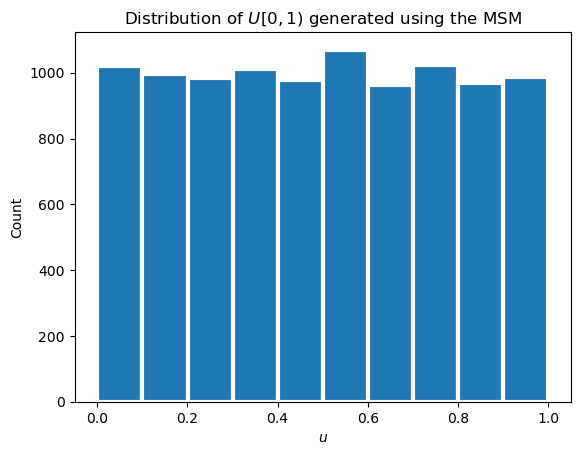

In [30]:
scaled_random_numbers_MSM = scale_to_unif_MSM(random_numbers_MSM, seed)
plt.hist(scaled_random_numbers_MSM, bins=10, align='mid', linewidth=3, edgecolor="white")
plt.xlabel("$u$")
plt.ylabel("Count")
plt.title("Distribution of $U[0,1)$ generated using the MSM")
plt.show()

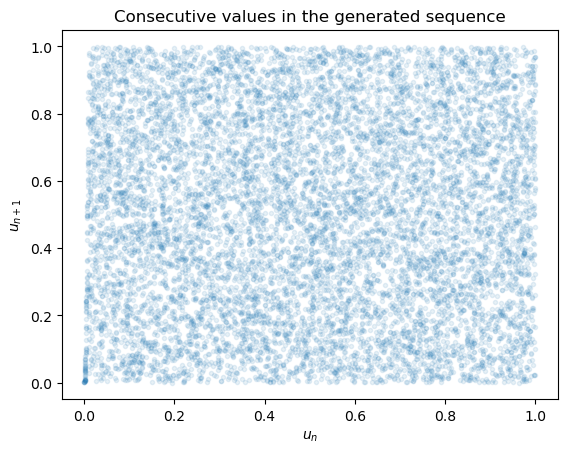

In [31]:
plt.plot(scaled_random_numbers_MSM[:-1], scaled_random_numbers_MSM[1:], ".", alpha=0.1)
plt.xlabel("$u_n$")
plt.ylabel("$u_{n+1}$")
plt.title("Consecutive values in the generated sequence")
plt.show()

These results seem to be uniform but if we try to generate more numbers, this method will generate null values indefinitely.

In [33]:
%%time
seed = 10253464
random_numbers_MSM = middle_square_method(seed, k=10**5)
random_numbers_MSM

CPU times: total: 203 ms
Wall time: 202 ms


array([13352399, 28655905, 16089136, ...,        0,        0,        0])

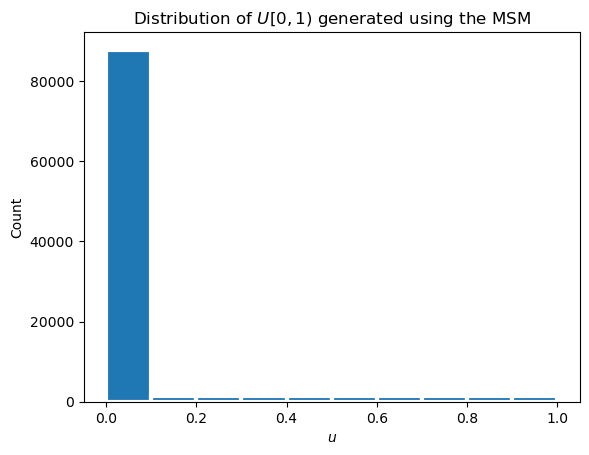

In [34]:
scaled_random_numbers_MSM = scale_to_unif_MSM(random_numbers_MSM, seed)
plt.hist(scaled_random_numbers_MSM, bins=10, align='mid', linewidth=3, edgecolor="white")
plt.xlabel("$u$")
plt.ylabel("Count")
plt.title("Distribution of $U[0,1)$ generated using the MSM")
plt.show()

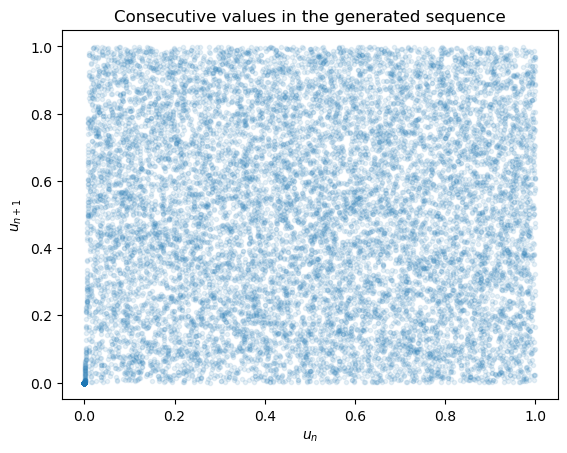

In [35]:
plt.plot(scaled_random_numbers_MSM[:-1], scaled_random_numbers_MSM[1:], ".", alpha=0.1)
plt.xlabel("$u_n$")
plt.ylabel("$u_{n+1}$")
plt.title("Consecutive values in the generated sequence")
plt.show()

In [36]:
random_numbers_MSM[10**4+3590:10**4+3610].tolist()

[3091175,
 55536288,
 27928481,
 5096,
 2596,
 673,
 45,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Starting from the $13.598$th generated number, the MSM generates a $0$ which will lead to generate zeroes forever.

This is one of the biggest problems this method has and why it's not used in practice.

Let's now see a more recent method that has been used in softwares and hardwares for decades.

### 2. Linear Congruential Generator (LCG)

The Linear Congruential Generator method consists of applying a linear function on the input and then compute a modulus.

$\text{output} = (a \text{ seed} + c) \text{ mod } m$

Then we repeat this operation on the output to get another number and so on.

Mathematically, we write:

$X_{n+1} = (a X_n + c) \, \text{ mod } \, m$

with 
* $m > 0$ the modulus,
* $a \in (0, m)$ the multiplier,
* $c \in [0, m)$ the increment,
* $X_0$ the seed

This method is really simple to understand and code, the difficulty is to choose good parameters. Some will give you bad generators and some good ones.

For example, with m = 10, a = 1 and c = 1 we will get a method that take the last digit and add one and then a cycle going through all the digits:

```
seed = 24354

output1 = (1*24354 + 1) % 10 = 24355 % 10 = 5
output2 = 6
output3 = 7
output4 = 8
output5 = 9
output6 = 0
output7 = 1
output8 = 2
...
```

We have uniformity but the outputs are fully predictible.

Usually and to be really simplistic, good parameters consist in having large numbers. The largest parameter is typically the modulus $m$, which directly influences the generator’s period. Another one is the slope $a$ of the linear form.
We will see this further below.

Let's see the code and then two examples.

In [44]:
def linear_congruential_generator(seed, m, a, c, k=1):
    ### parameters validity test
    if m > 0 and (0 < a < m) and (0 <= c < m):
        outputs = np.zeros(k).astype(int) # the result will be a numpy array
        number = seed
    
        ### each iteration of the loop will produce one number
        for i in range(k):

            ## compute the next number
            output = (a*number + c) % m

            ## add the result in the outputs array
            outputs[i] = int(output)
    
            ## the output is now the next input
            number = output

        return outputs

    else:
        print(f"The parameters m={m}, a={a} and c={c} are not valid.")
        return None

The function to scale the numbers to the $[0,1)$ interval:

In [46]:
def scale_to_unif_LCG(x, m):
    return x/m

* **RANDU** [[2]](https://en.wikipedia.org/wiki/RANDU)

This generator is an example of poor choices in terms of parameters and defined such as:

$X_{n+1} = 65539 \, X_n \text{ mod } 2^{31}$

We can read on the LCG wikipedia page that it was "widely used in the early 1970s and led to many results which are currently being questioned because of the use of this poor LCG". 

Let's try it:

In [48]:
seed = 1025
m, a, c = 2**31, 65539, 0
random_numbers_LCG = linear_congruential_generator(seed, m, a, c, k=10**5)
random_numbers_LCG

array([  67177475,  403055625, 1813736475, ..., 1265467065, 1627487275,
        523203713])

In [49]:
scaled_random_numbers_LCG = scale_to_unif_LCG(random_numbers_LCG, m)
scaled_random_numbers_LCG

array([0.03128195, 0.1876874 , 0.84458686, ..., 0.58927902, 0.75785782,
       0.24363571])

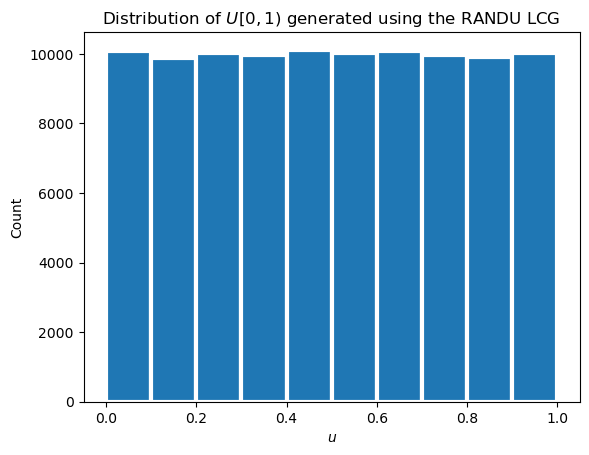

In [50]:
plt.hist(scaled_random_numbers_LCG, bins=10, align='mid', linewidth=3, edgecolor="white")
plt.xlabel("$u$")
plt.ylabel("Count")
plt.title("Distribution of $U[0,1)$ generated using the RANDU LCG")
plt.show()

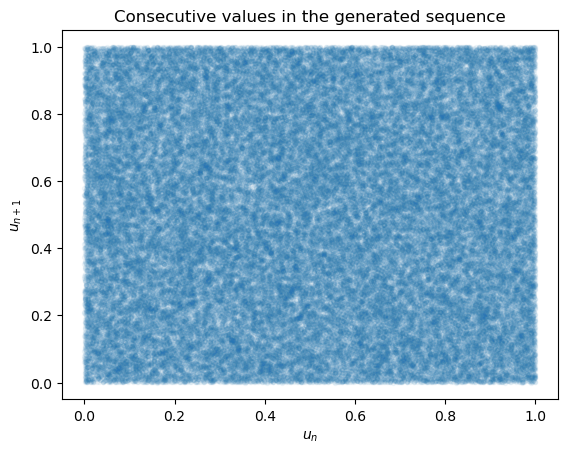

In [51]:
plt.plot(scaled_random_numbers_LCG[:-1], scaled_random_numbers_LCG[1:], ".", alpha=0.05)
plt.xlabel("$u_n$")
plt.ylabel("$u_{n+1}$")
plt.title("Consecutive values in the generated sequence")
plt.show()

This generator seems to do what we are expecting it to do!

There are complex tests that allow to tell if a generator is rather good or not.

One of these methods is the spectral test (which can only be used for LCGs), and RANDU fails it in dimensions higher than 2.

Here's a visualization why in 3 dimensions:

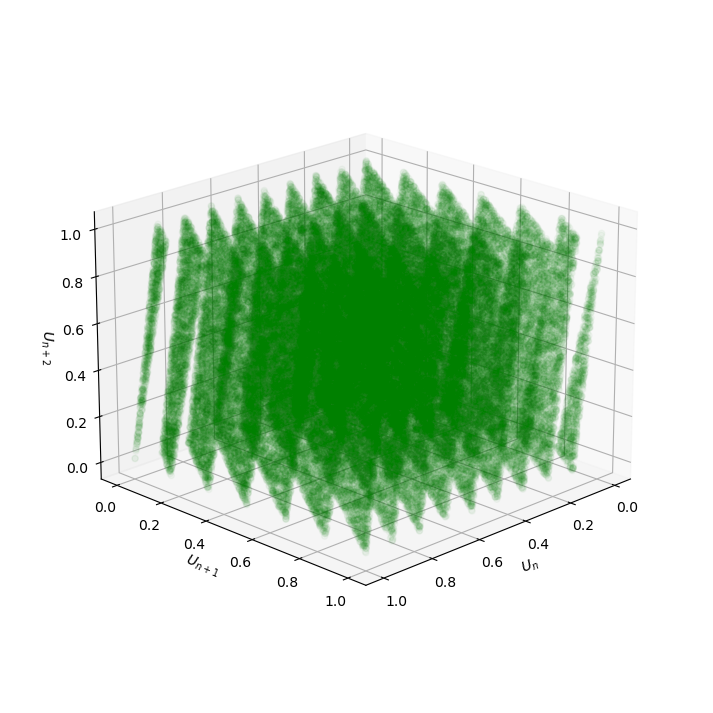

In [53]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    scaled_random_numbers_LCG[:-2], 
    scaled_random_numbers_LCG[1:-1],
    scaled_random_numbers_LCG[2:], 
    color = "green", alpha=0.03)
    
ax.set_xlabel('$U_n$')
ax.set_ylabel('$U_{n+1}$')
ax.set_zlabel('$U_{n+2}$')

ax.view_init(elev=20., azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.85)

plt.show()

We can clearly see planes which means that the process is not random at all.
There is a pattern that links each 3 consecutives generated values.

* **Minimal standard**

This generator is an example of a rather good LCG:

$X_{n+1} = 16807 \, X_n \text{ mod } 2^{31} - 1$

In [57]:
%%time
seed = 1025
m = 2**31 - 1
c = 0
a = 7**5
random_numbers_LCG = linear_congruential_generator(seed, m, a, c, k=10**5)
random_numbers_LCG

CPU times: total: 31.2 ms
Wall time: 31 ms


array([  17227175, 1774321527, 1063982047, ..., 1887156762, 1257716391,
        757846116])

In [58]:
scaled_random_numbers_LCG = scale_to_unif_LCG(random_numbers_LCG, m)
scaled_random_numbers_LCG

array([0.00802203, 0.82623285, 0.49545525, ..., 0.87877585, 0.58566983,
       0.3528996 ])

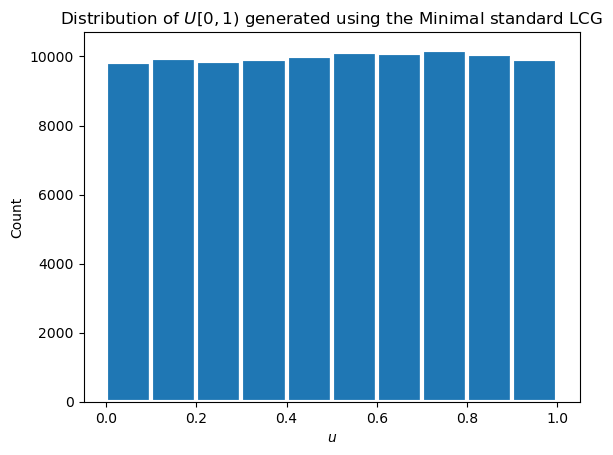

In [59]:
plt.hist(scaled_random_numbers_LCG, bins=10, align='mid', linewidth=3, edgecolor="white")
plt.xlabel("$u$")
plt.ylabel("Count")
plt.title("Distribution of $U[0,1)$ generated using the Minimal standard LCG")
plt.show()

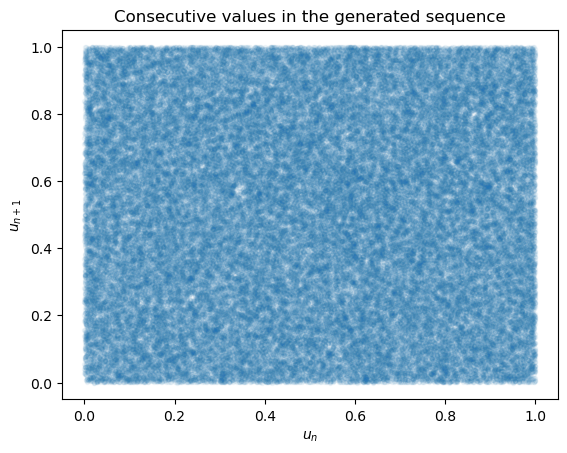

In [60]:
plt.plot(scaled_random_numbers_LCG[:-1], scaled_random_numbers_LCG[1:], ".", alpha=0.05)
plt.xlabel("$u_n$")
plt.ylabel("$u_{n+1}$")
plt.title("Consecutive values in the generated sequence")
plt.show()

And this time we can't see obvious patterns in the 3D plot:

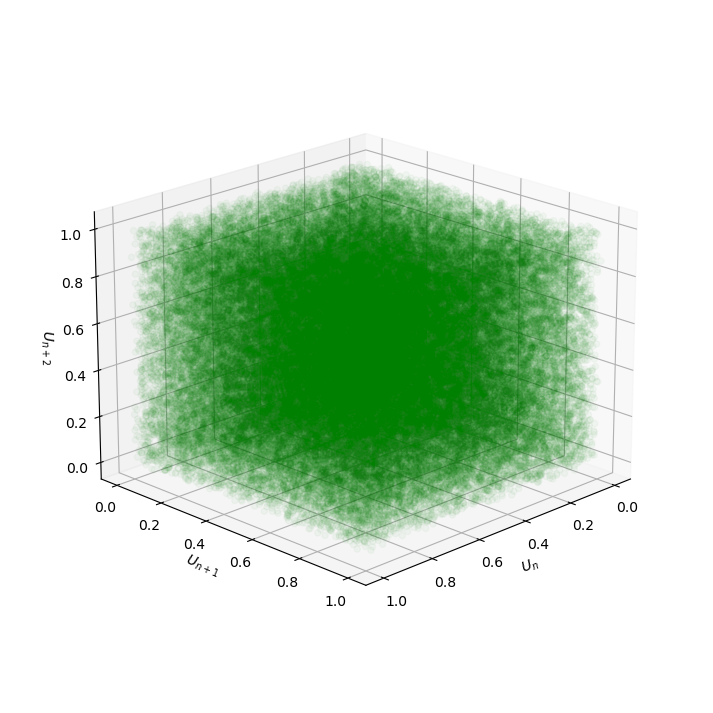

In [62]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    scaled_random_numbers_LCG[:-2], 
    scaled_random_numbers_LCG[1:-1],
    scaled_random_numbers_LCG[2:], 
    color = "green", alpha=0.03)
    
ax.set_xlabel('$U_n$')
ax.set_ylabel('$U_{n+1}$')
ax.set_zlabel('$U_{n+2}$')

ax.view_init(elev=20., azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.85)

plt.show()

This doesn't mean that this generator is perfect, tests have been made on these methods to get the best parameters and you could choose better one.
There are also variants of this kind of generator.

But it's time now to introduce you the best of these three generators and still used today!

### 3. Mersenne Twister

The Mersenne Twister is way more complex than the previous ones but way much better. 
Although it is very popular and has excellent statistical properties, it is not cryptographically secure—if you need cryptographic randomness, you should use a different type of generator.

But let's try to understand the global picture.

This generator consists in:
 1. **Initialization:** fill an internal array of $n$ 32‐bit integers from the seed
 2. **Twist:** then repeatedly shift and mix these values together using bitwise operations to produce the next state of the array
 3. **Temper:** apply a final set of bitwise transformations to each output to improve its distribution of bits

There is a lot of parameters for this method and here we are going to choose those from the "standard" MT19937 version implemented in R.

Here are the standard MT19937 parameters:
```
(w, n, m, r, u, s, t, l) = (32, 624, 397, 31, 11, 7, 15, 18)
(a, b, c) = (0x9908b0df, 0x9d2c5680, 0xefc60000)
(lower, upper, d) = (0x7fffffff, 0x80000000, 0xffffffff)
```

If we want to write the details of the method properly it will be:

#### 1. initialization step (only once):

We compute a large number: $n_{51}$ such as $n_i = 69069 \, n_{i-1} + 1$ with $n_0 = \text{ seed}$

Then we keep using this sequence but in order to fill our list of numbers, we are going to take only the last binary digits using the $\&$ operator and the $d=FFFFFFFF_{16}$ value: 

$x_0 = (69069 \, n_{51} + 1) \, \& \, d$

$x_i = (69069 \, x_{i-1} + 1) \, \& \, d$, with $1 \le i \lt n$

Then we have the $n$ numbers: $x_0, x_1, \ldots, x_{n-1}$


#### 2. twist step (after step 1. and then each time we have generated $n$ numbers):

We transform all the $x_i$ into $y_i$ using $x_i \,$, $\, \, x_{(i+1) \text{ mod } n} \,$ and $\, x_{(i + m) \text{ mod } n}$:

* $e_i = (x_i \, \, \& \, \text{ upper}) + (x_{(i+1) \text{ mod } n} \, \, \& \, \text{ lower})$
* $f_i = e_i >> 1$
* if $e_i$ is odd then $f_i = f_i \oplus a$
* $y_i = x_{(i + m) \text{ mod } n} \oplus f_i$

We have the $n$ twisted numbers: $y_0, y_1, \ldots, y_{n-1}$
    
#### 3. temper step (each time we want to generate one number):

For each number to be generated we are going to go through this whole process of bitwise operations and bit shifts: 

* $g_1 = y_j$
* $g_2 = g_1 \oplus ((g_1 >> u) \, \& \, d)$
* $g_3 = g_2 \oplus ((g_2 << s) \, \& \, b)$
* $g_4 = g_3 \oplus ((g_3 << t) \, \& \, c)$
* $g_5 = g_4 \oplus (g_4 >> l)$
* $z_j = g_5 \, \& \, d$ 

We have transformed $y_j$ into $z_j$ which is the $j$-th generated number.

Let's say we want to generate $K$ numbers which is greater than $n$. Once we have done this temper step on all these $n$ twisted numbers ($y_i$) then we go back on the twist step before generating the others numbers with temper.

Another way to understand it - that I highly suggest you to give it a try - is to watch this fantastic video from the **Statistics Crystallized** Youtube channel which illustrates this algorithm with great animations:

**Episode#1 - PRNGs (Mersenne-Twister, Middle Square)**

[https://www.youtube.com/watch?v=QTk2AxzZYfc](https://www.youtube.com/watch?v=QTk2AxzZYfc)

Let's see the code of these three steps:

First, a class to store our parameters and be sure that they won't change one way or another:

In [69]:
class MTparams():
    f = 1812433253
    (w, n, m, r, u, s, t, l) = (32, 624, 397, 31, 11, 7, 15, 18)
    (a, b, c) = (0x9908b0df, 0x9d2c5680, 0xefc60000)
    (lower, upper, d) = (0x7fffffff, 0x80000000, 0xffffffff)

Now, the initialization step:

In [71]:
def initialize_MT(seed):

    # 1. grow_input_seed
    number = seed
    for i in range(1, 51 + 1):
        number = 69069*number + 1

    # 2. sow_seed
    MT = np.zeros(MTparams.n).astype(np.int64)  
    g_prev = number
    for i in range(MTparams.n):
        g_new = 69069*g_prev + 1
        MT[i] = g_new & 0xffffffff
        g_prev = g_new
    
    return MT

Before testing it, let's take the same seed as used in the video:

In [73]:
seed = 1958

The initialization step:

In [75]:
MT = initialize_MT(seed)
MT

array([1024764258, 2676465019, 1075010176, 2778200193, 1255246926,
        440094839, 1426881100,  931121885, 3112152058, 3002231091,
         78173400,  584673529, 1533457510,  483238831,  631961124,
       3465211605, 1647776146, 2207218667,  521939504, 2179086449,
       3077959550, 3591908839, 3650649340, 2054218189, 2846439978,
       2929833379, 3277503112, 3316139753,  440638870,  347852575,
       4077416148, 2050327493,  407930306,  352843355,  893248992,
       2904388705, 2480938670, 3937757015, 2430217132, 1050195133,
       2519946330,  918363667, 2383088696, 1521459417,  715641542,
       2162022031, 1276711812, 1234588853, 3831760370, 4267183307,
        838045072, 3955797073, 2898467294, 1516895431, 3313272412,
       4259726253, 1182857866, 4237009539, 4120168936,    5142217,
       2980467702,  141212159, 3806848052, 1585209765, 1546949154,
        329695035, 4084736320,  841146433, 3415335182, 1296887351,
       3169488140, 3188231837,  716516538, 2467578611,  294843

Here are the $x_0, x_1, \ldots, x_{n-1}$.

Second step, the twist function:

In [78]:
def twist(MT):
    Twisted_MT = MT.copy()
    for i in range(MTparams.n):
        x = (MT[i] & MTparams.upper) + (MT[(i+1) % MTparams.n] & MTparams.lower)
        xA = x >> 1
        if (x % 2) != 0:
            xA = xA ^ MTparams.a
        Twisted_MT[i] = MT[(i + MTparams.m) % MTparams.n] ^ xA
    return Twisted_MT

In [79]:
Twisted_MT = twist(MT)
Twisted_MT

array([ 531208269, 2417499108, 1356519882,  806232117,  389168783,
         54398870, 2004144960, 1591844355, 4214047777, 3173394192,
        563567854, 3860186265, 3192639787, 2677516314, 3893338844,
       2795569887, 1538702517,  664361548, 1090283170, 2224524797,
       1927735031, 2677551134, 3378160344, 1019414075,  648999897,
       3431809384, 2609666198, 1264588305, 2697129923, 2230678482,
       1559965284, 1077517735,  577180413, 3376867060, 1050030554,
       2445677861,  290387007, 1751565254, 3744321616, 3876068467,
       1687810193, 4130541760, 1902418590, 2746971753, 2114094747,
        772647850, 1741443020, 1945731727, 1674930885, 1067893372,
        871042770, 4263660109,   29492999,  312789742, 2147786696,
        721412299, 3249668393, 2850740600, 2706140838, 1198446785,
       2628383059,  402562562, 2413971252,  178267319, 3730494637,
       2429235652,  576852458, 1376882261, 2093219823,  470708214,
       2703632672, 4228826851, 2715737985, 3451972080,  846125

Here are the $y_0, y_1, \ldots, y_{n-1}$.

And finally the temper function:

In [82]:
def temper(Twisted_MT, pos_index):
    y1 = Twisted_MT[pos_index]
    y2 = y1 ^ ((y1 >> MTparams.u) & MTparams.d)
    y3 = y2 ^ ((y2 << MTparams.s) & MTparams.b)
    y4 = y3 ^ ((y3 << MTparams.t) & MTparams.c)
    y5 = y4 ^ (y4 >> MTparams.l)
    y6 = y5 & MTparams.d
    return y6

`pos_index` is a parameter that will be incremented every time a number is generated. 
It enables us to know when to apply the twist function.

Here is the first random number generated:

In [84]:
temper(Twisted_MT, 0)

2802340540

Finally, here is the code of the generator:

In [86]:
def mersenne_twister_generator(seed, k=1, integer=False, verbose=False):
    """
    Generates a numpy array of k pseudorandom numbers using the MT19937 (32 bits) 
    version of Mersenne Twister as implemented in R.

    Args:
        seed (int): the seed used for numbers generation.
        k (int): the number of pseudorandom number to be generated.
        integer (bool): if True, the function generates integer random numbers, 
            otherwise it generates values to the [0,1) interval.
        verbose (bool): if True, the function displays the progression of number generation.

    Returns:
        numpy.array: the sequence of k random numbers.
    """
    ### outputs array initialization
    if integer:
        integer_outputs = np.zeros(k).astype(np.int64)
    else:
        decimal_outputs = np.zeros(k).astype(np.float64)

    ### increment variables
    item = 1
    pos_index = MTparams.n
    
    ### initialization step
    MT = initialize_MT(seed)

    ### loop run for each number to be generated
    Twisted_MT = MT.copy()
    while item <= k:
        ## first loop or each time n numbers have been generated
        if pos_index > MTparams.n - 1:
            # twist step
            Twisted_MT = twist(Twisted_MT)
            pos_index = 0
            
        ## temper step
        output = temper(Twisted_MT, pos_index)

        ## add the result in the outputs array   
        if integer:
            integer_outputs[item-1] = output
        else:
            decimal_outputs[item-1] = output/2**MTparams.w # -> [0,1) interval

        ## updates of increment variables
        pos_index += 1
        item += 1

        ## display of the algorithm progression
        if verbose:
            print(f"\r{round(100*item/k)}%", end="")
    if verbose:
        print()

    ### return outputs
    if integer:
        return integer_outputs
    else:
        return decimal_outputs

Let's run the example of the video:

In [88]:
mersenne_twister_generator(seed, k=2, integer=False)

array([0.65247075, 0.68756714])

That's it, we got the same results!

Now let's look at the graphs.

In [91]:
%%time
scaled_random_numbers_MT = mersenne_twister_generator(seed, k=10**5, integer=False, verbose=True)
scaled_random_numbers_MT

100%
CPU times: total: 1.12 s
Wall time: 1.14 s


array([0.65247075, 0.68756714, 0.10132625, ..., 0.26466224, 0.07524375,
       0.79609317])

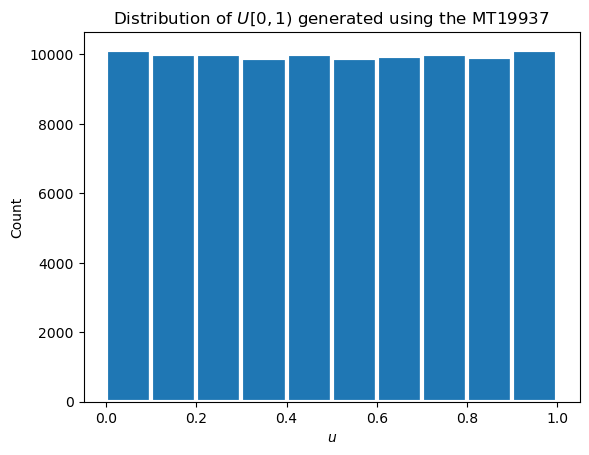

In [92]:
plt.hist(scaled_random_numbers_MT, bins=10, align='mid', linewidth=3, edgecolor="white")
plt.xlabel("$u$")
plt.ylabel("Count")
plt.title("Distribution of $U[0,1)$ generated using the MT19937")
plt.show()

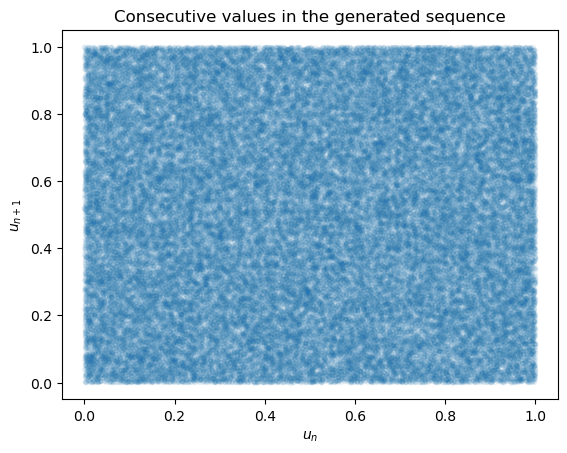

In [93]:
plt.plot(scaled_random_numbers_MT[:-1], scaled_random_numbers_MT[1:], ".", alpha=0.05)
plt.xlabel("$u_n$")
plt.ylabel("$u_{n+1}$")
plt.title("Consecutive values in the generated sequence")
plt.show()

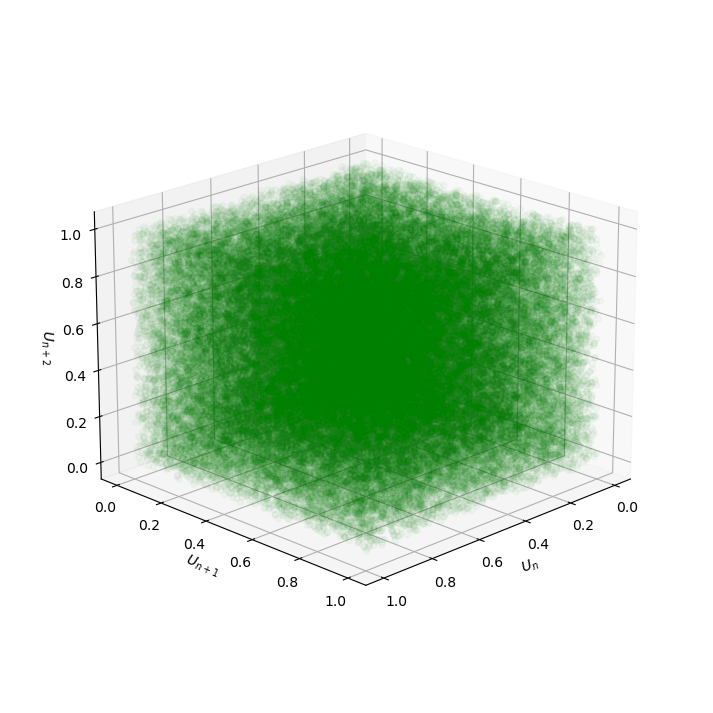

In [94]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    scaled_random_numbers_MT[:-2], 
    scaled_random_numbers_MT[1:-1],
    scaled_random_numbers_MT[2:], 
    color = "green", alpha=0.03)
    
ax.set_xlabel('$U_n$')
ax.set_ylabel('$U_{n+1}$')
ax.set_zlabel('$U_{n+2}$')

ax.view_init(elev=20., azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.85)

plt.show()

Of course looking at these graphs is not enough to say whether it's a good generator. It gives just a first look and tell if the generator is really really bad or better than that.

In practice, one uses statistical test batteries (e.g., TestU01) to judge generator quality. Visual checks help us spot patterns, but a generator can still have subtle correlations that only specialized tests can reveal.

If you are interested in generating random number for cryptographic purposes, you will need to go deeper on this field and use ryptographically secure algorithms.

## Wrapping Up and Next Steps

PRNGs methods we've seen:
* **Middle‐square:** historically interesting but can quickly degrade into zeros.
* **LCG:** simple, fast, but can have obvious patterns if poorly parameterized (e.g., RANDU).
* **Mersenne Twister:** widely used for simulations, has a huge period, but not cryptographically secure.

Others popular methods:
* **Linear-feedback shift register** (LFSR)
* **Xorshift**
* **Permuted Congruential Generator** (PCG)
* **xoshiro**




I hope that you'll have now a clearer picture of how random number generation works, that it seems to be less magical.

How I understand it in a simple way is that these methods compute a large number based on the seed and try to extract a subset of it.
Getting a large number seems to add randomness in the result and the step of extracting a subset of it seems to try to get the part the most likely to be random.
For example in the middle-square method we square the input to make it larger and we extract the middle digits. If we wanted to extract the last digits we will get a lot of correlations between the successive numbers. If you start with an even seed in the middle‐square method, squaring it always gives you an even result. So taking the middle digits really makes sense to have the most possible randomness with this method.

One next step that seems to be really fascinating is that from random values that follow the uniform [0,1) distribution (what we've done here) we can generate values for every probability distributions. Once again you will find an introduction with this video from the **Statistics Crystallized** Youtube channel: **The menu of probability distributions in numpy** ([https://www.youtube.com/watch?v=o6_LqMOpXBg](https://www.youtube.com/watch?v=o6_LqMOpXBg)).

There are many PRNGs, especially those for cryptographic applications, which require more robust methods to avoid hacks as much as possible. If an adversary can figure out the internal state or method of a weak PRNG, they can predict all its outputs. That’s why cryptographic applications require specialized, secure algorithms often called **CSPRNGs**.

I hope you enjoyed this behind‐the‐scenes look at how pseudorandom numbers are made! Feel free to share your thoughts or improvements and thank you for reading! :)

---

Here's a list of interesting videos I've found:

- Middle Square and Mersenne-Twister: [https://www.youtube.com/watch?v=QTk2AxzZYfc](https://www.youtube.com/watch?v=QTk2AxzZYfc)
- Linear Congruential Generators: [https://www.youtube.com/watch?v=kRCmR4qr-hQ](https://www.youtube.com/watch?v=kRCmR4qr-hQ)
- Linear Feedback Shift Register: [https://www.youtube.com/watch?v=Ks1pw1X22y4](https://www.youtube.com/watch?v=Ks1pw1X22y4)
- Randomness and PRNGs (LCG and Mersenne-Twister): [https://www.youtube.com/watch?v=_tN2ev3hO14](https://www.youtube.com/watch?v=_tN2ev3hO14)
- The menu of probability distributions in numpy: [https://www.youtube.com/watch?v=o6_LqMOpXBg](https://www.youtube.com/watch?v=o6_LqMOpXBg)